### Multilingual Offline Forged Signatures using SNN and FSL

In [1]:
!pip install keras

In [2]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense

from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
path = "/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali"

In [4]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [5]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(os.path.join(path, directory))  # Fixed path concatenation
    images.sort()
    images = [os.path.join(path, directory, x) for x in images]  # Fixed path concatenation
    forg_groups.append(images[:30])  # First 30 signatures in each folder are forged
    orig_groups.append(images[30:])  # Next 24 signatures are genuine

In [6]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(25, 25)

In [7]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [8]:

# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [9]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


## Train-Validation-Test Split
Signatures of 120 people are used for training
Signatures of 20 people are used for validation
Signatures of 20 people are used for testing

In [10]:
orig_train, orig_test = orig_groups[:20], orig_groups[20:]
forg_train, forg_test = forg_groups[:20], forg_groups[20:]

In [11]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [12]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

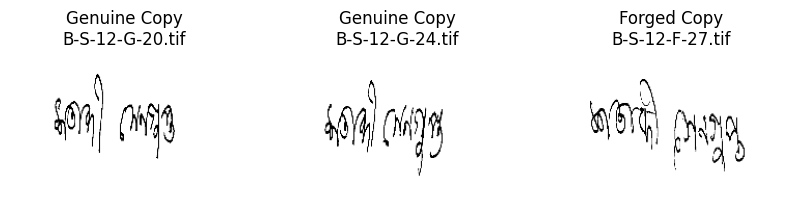

In [13]:
def visualize_sample_signature(orig_train, forg_train, img_w, img_h):
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap='gray')
    ax2.imshow(orig_img2, cmap='gray')
    ax3.imshow(forg_img, cmap='gray')

    ax1.set_title('Genuine Copy\n{}'.format(os.path.basename(orig_img_names[0])))
    ax1.axis('off')
    ax2.set_title('Genuine Copy\n{}'.format(os.path.basename(orig_img_names[1])))
    ax2.axis('off')
    ax3.set_title('Forged Copy\n{}'.format(os.path.basename(forg_img_name[0])))
    ax3.axis('off')

# Example usage:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)
plt.show()

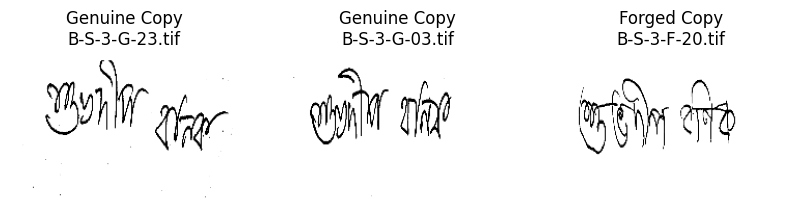

In [14]:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)

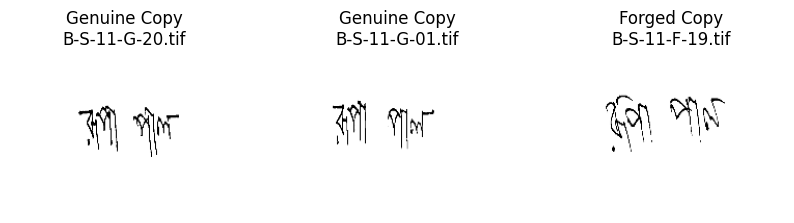

In [18]:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)

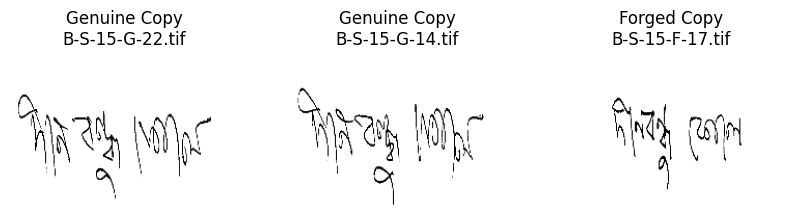

In [19]:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)

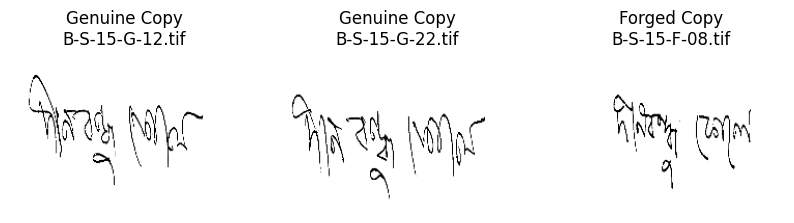

In [20]:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)

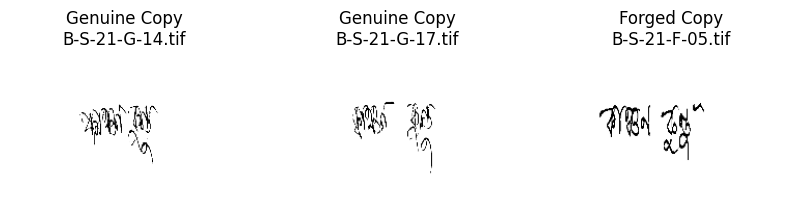

In [21]:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)

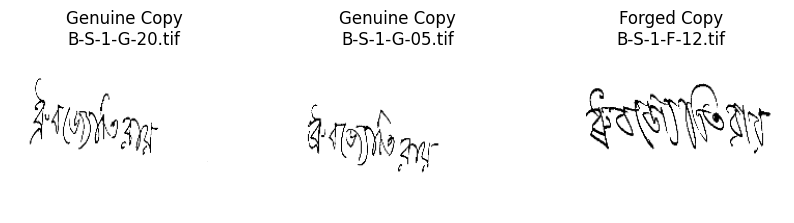

In [17]:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)

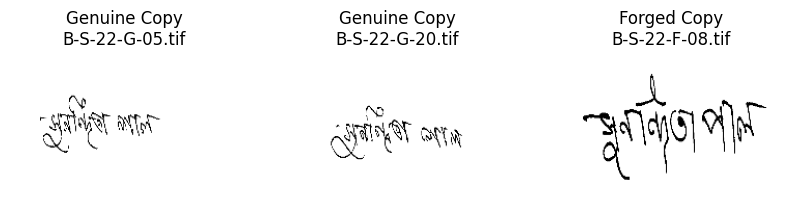

In [15]:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)

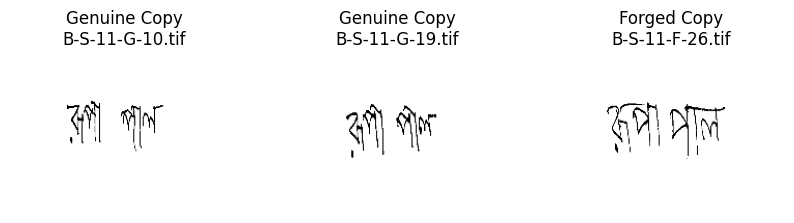

In [16]:
visualize_sample_signature(orig_train, forg_train, img_w, img_h)

In [22]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 25 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 25 * 276 = 6900
        # Total number of Genuine-Forged pairs = 120 * 300 = 7500
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)

        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.

        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [23]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [24]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [25]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.regularizers import l2

def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape=input_shape,
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(ZeroPadding2D((2, 2)))

    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3)) # Added extra dropout
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3)) # Added extra dropout
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))

    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))

    return seq


In [27]:
input_shape=(img_h, img_w, 1)

In [28]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [29]:
batch_sz = 128
num_train_samples = 276 * 20 + 300 * 20  # 20 persons for training
num_test_samples = 276 * 5 + 300 * 5     # 5 persons for testing
num_train_samples, num_test_samples

(11520, 2880)

In [30]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

## FOR VALIDATION

In [ ]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

### TO COMPUTE THE ACCURACY AND THRESHOLD

In [31]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)

    step = 0.01
    max_acc = 0
    best_thresh = -1

    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d

        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)
#       print ('ROC', acc, tpr, tnr)

        if (acc > max_acc):
            max_acc, best_thresh = acc, d

    return max_acc, best_thresh

In [32]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

1/1 [==============================] - 0s 63ms/step


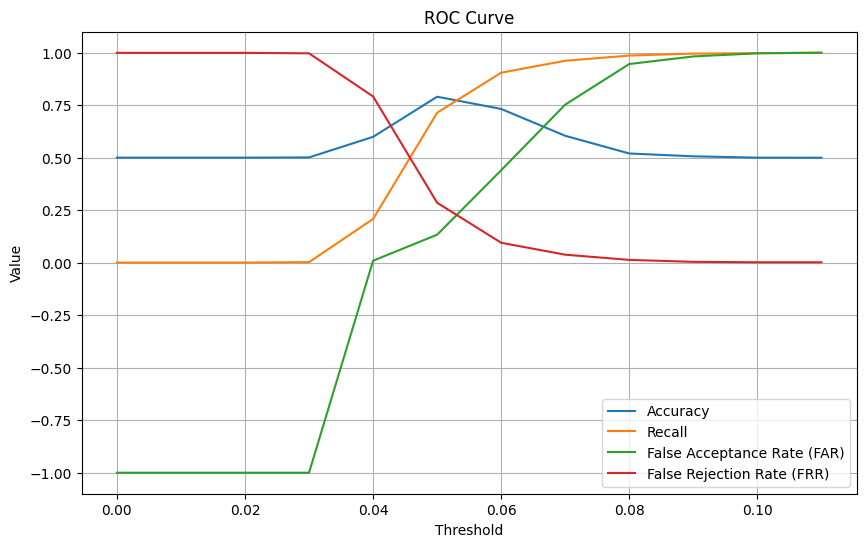

Accuracy: 0.7904814307886252
Threshold: 0.05
Recall: 1.0
False Acceptance Rate (FAR): 1.0
False Rejection Rate (FRR): 0.002126151665485471


In [63]:
# to compute accuracy, thresholds, FRR, and FAR
# tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
# tr_acc, threshold


# to compute to compute accuracy, thresholds, FRR, FAR, and recall
import matplotlib.pyplot as plt

def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
    step = 0.01
    max_acc = 0
    best_thresh = -1
    recall = far = frr = -1

    acc_list = []
    recall_list = []
    far_list = []
    frr_list = []
    thresh_list = []

    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d

        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)
        fpr = 1 - tnr

        if np.sum(labels[idx1] == 0) > 0:
            far = np.sum(labels[idx1] == 0) / float(ndiff)
        if np.sum(labels[idx2] == 1) > 0:
            frr = np.sum(labels[idx2] == 1) / float(nsame)

        recall = tpr

        acc_list.append(acc)
        recall_list.append(recall)
        far_list.append(far)
        frr_list.append(frr)
        thresh_list.append(d)

        if acc > max_acc:
            max_acc, best_thresh = acc, d

    plt.figure(figsize=(10, 6))
    plt.plot(thresh_list, acc_list, label='Accuracy')
    plt.plot(thresh_list, recall_list, label='Recall')
    plt.plot(thresh_list, far_list, label='False Acceptance Rate (FAR)')
    plt.plot(thresh_list, frr_list, label='False Rejection Rate (FRR)')
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return max_acc, best_thresh, recall, far, frr

tr_acc, threshold, recall, far, frr = compute_accuracy_roc(np.array(pred), np.array(tr_y))
print("Accuracy:", tr_acc)
print("Threshold:", threshold)
print("Recall:", recall)
print("False Acceptance Rate (FAR):", far)
print("False Rejection Rate (FRR):", frr)


# Accuracy = 79.04% and Threshold = 0.05

Thus if the differnce score is less than 0.05, we predict the test image as Genuine and if the difference score is greater than 0.05, we predict it to be as forged

In [65]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

Note: The first image is always Genuine. Score prediction and classification is done for the second image

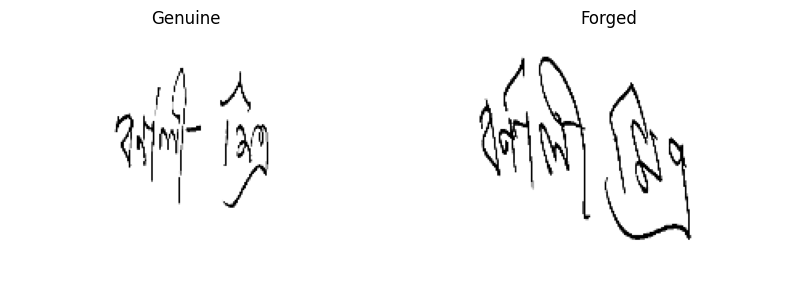

1/1 [==============================] - 0s 124ms/step
Difference Score =  0.06827144
Its a Forged Signature


In [66]:
predict_score()

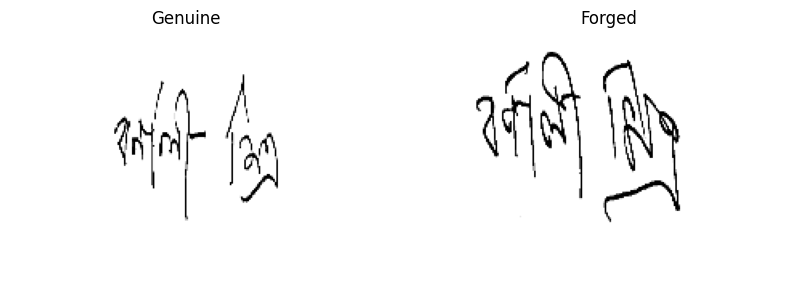

1/1 [==============================] - 0s 75ms/step
Difference Score =  0.06818364
Its a Forged Signature


In [67]:
predict_score()

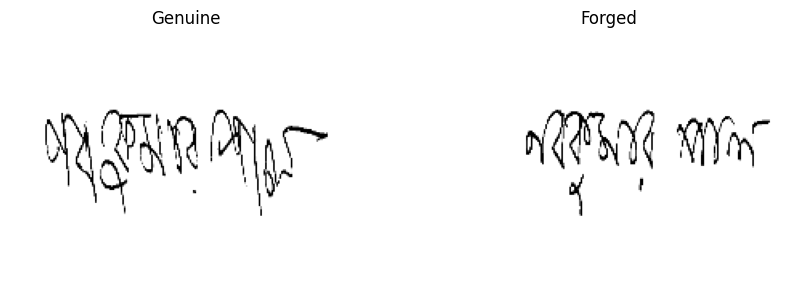

1/1 [==============================] - 0s 75ms/step
Difference Score =  0.055240307
Its a Forged Signature


In [68]:
predict_score()

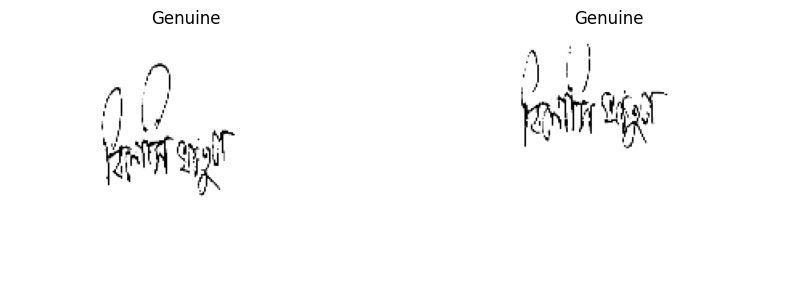

1/1 [==============================] - 0s 67ms/step
Difference Score =  0.059055846
Its a Forged Signature


In [69]:
predict_score()

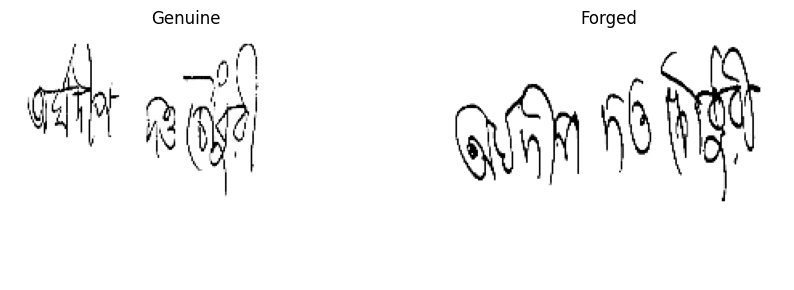

1/1 [==============================] - 0s 66ms/step
Difference Score =  0.08015497
Its a Forged Signature


In [70]:
predict_score()

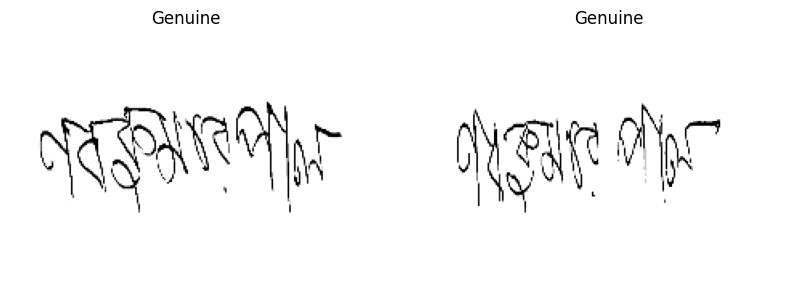

1/1 [==============================] - 0s 69ms/step
Difference Score =  0.04993396
Its a Genuine Signature


In [54]:
predict_score()

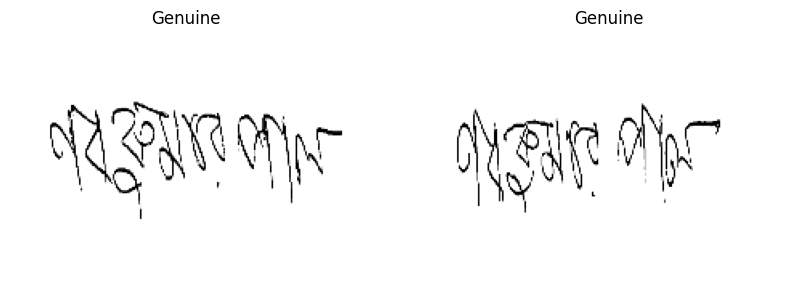

1/1 [==============================] - 0s 69ms/step
Difference Score =  0.05397005
Its a Forged Signature


In [55]:
predict_score()

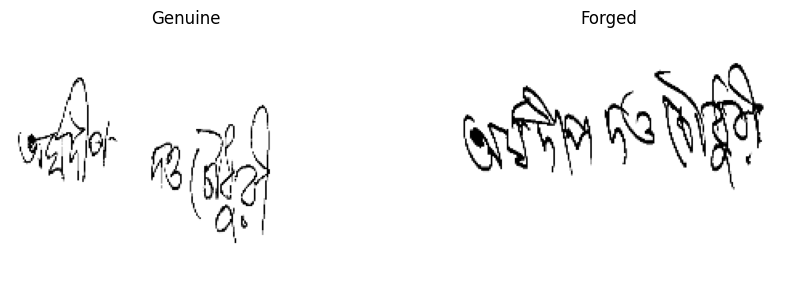

1/1 [==============================] - 0s 70ms/step
Difference Score =  0.07828073
Its a Forged Signature


In [56]:
predict_score()

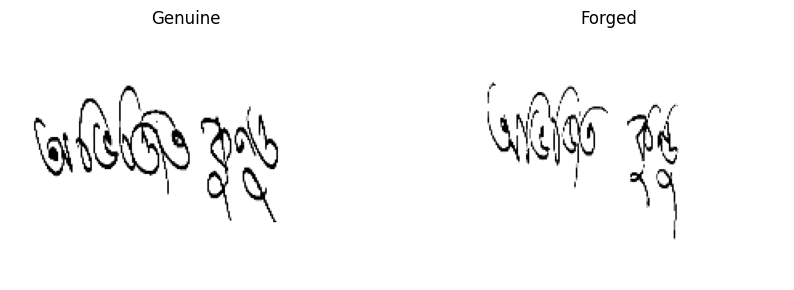

1/1 [==============================] - 0s 73ms/step
Difference Score =  0.05246148
Its a Forged Signature


In [57]:
predict_score()